In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
import configs

device = 'cpu'

In [266]:
np.random.seed(0)

In [267]:
num_steps = 4000
num_states = 20

In [268]:
# Right-biased 1D Walk
dset = inputs.Sim1DWalk(
    num_steps=num_steps, left_right_stay_prob=[0.5, 1.5, 1],
    num_states=num_states
    )

In [269]:
# Set up network
save_path = '../trained_models/baseline0.4/'
model_path = save_path + 'model.pt'
net_configs_path = save_path + 'net_configs.p'
with open(net_configs_path, 'rb') as f:
    net_configs = pickle.load(f)
net_configs.pop('num_states')
net = STDP_SR(num_states=num_states, **net_configs)
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [270]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
input_states = []
for t in range(dg_inputs.shape[0]):
    input_states.append(np.argwhere(dg_inputs[t,0])[0,0])
input_states = np.array(input_states)

In [271]:
# Get lap start indices
lap_starts = [0]
state_counts = np.zeros(num_states)
for t, input_state in enumerate(input_states):
    if not np.any(state_counts == 0):
        lap_starts.append(t)
        state_counts = np.zeros(num_states)
    state_counts[input_state] += 1
lap_starts = np.array(lap_starts)

# Run network

In [272]:
Ms = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    curr_dg_mode = dg_modes[step].unsqueeze(0)
    reset = True if step == 0 else False
    _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
    if step in lap_starts:
        Ms.append(net.get_M(0.99))

# Plot place field induction laps

In [273]:
for state in np.unique(input_states):
    first_t = np.argwhere(input_states == state)[0,0]
    print(f'State {state} first encountered in {first_t}')

State 0 first encountered in 58
State 1 first encountered in 0
State 2 first encountered in 2
State 3 first encountered in 3
State 4 first encountered in 4
State 5 first encountered in 5
State 6 first encountered in 6
State 7 first encountered in 9
State 8 first encountered in 11
State 9 first encountered in 12
State 10 first encountered in 32
State 11 first encountered in 33
State 12 first encountered in 36
State 13 first encountered in 37
State 14 first encountered in 40
State 15 first encountered in 41
State 16 first encountered in 49
State 17 first encountered in 50
State 18 first encountered in 51
State 19 first encountered in 57


In [294]:
chosen_state = 8
num_laps = 10
M_vectors = [M[chosen_state,:].detach().numpy() for M in Ms]
M_vectors = np.array(M_vectors)

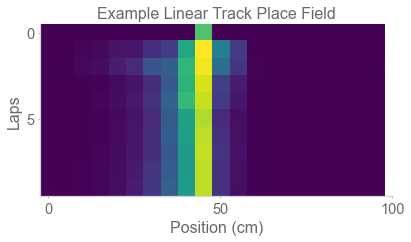

In [302]:
plt.figure(figsize=(6,4))
fields = M_vectors[:num_laps]
fields = np.fliplr(fields)
fields = np.roll(fields, shift=(num_states//2)+chosen_state, axis=1)
plt.imshow(fields, cmap='viridis')
plt.yticks(np.arange(0, num_laps, 5))
plt.ylabel('Laps')
tick_locs = np.array([0, 50, 100]) # In cm
plt.xticks(tick_locs/configs.bin_to_cm, tick_locs)
plt.xlabel('Position (cm)')
plt.title(f'Example Linear Track Place Field')
plt.savefig('field_induction.png', dpi=200)
plt.tight_layout()
plt.show()

# Plot Ms for different walk biases

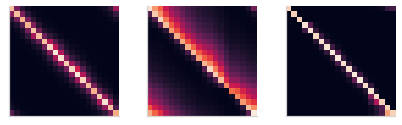

In [304]:
lrs_ps = [
    [1, 1, 1],
    [1, 5, 1],
    [1, 1, 5]
]

fig, axs = plt.subplots(1,3, figsize=(6,2))
for idx, lrs_p in enumerate(lrs_ps):
    num_steps = 1000
    num_states = 20

    # Right-biased 1D Walk
    dset = inputs.Sim1DWalk(
        num_steps=num_steps, left_right_stay_prob=lrs_p,
        num_states=num_states
        )

    # Set up network
    save_path = '../trained_models/baseline0.4/'
    model_path = save_path + 'model.pt'
    net_configs_path = save_path + 'net_configs.p'
    with open(net_configs_path, 'rb') as f:
        net_configs = pickle.load(f)
    net_configs.pop('num_states')
    net = STDP_SR(num_states=num_states, **net_configs)
    net.load_state_dict(torch.load(model_path))
    
    # Set up dataset
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
    dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
    input_states = []
    for t in range(dg_inputs.shape[0]):
        input_states.append(np.argwhere(dg_inputs[t,0])[0,0])
    input_states = np.array(input_states)
    
    for step in range(dset.num_steps):
        curr_dg_input = dg_inputs[step].unsqueeze(0)
        curr_dg_mode = dg_modes[step].unsqueeze(0)
        reset = True if step == 0 else False
        _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
        
    ax = axs[idx]
    ax.imshow(net.get_M(0.99).detach().numpy().squeeze())
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.savefig('1dbias_Ms.png', dpi=200)
plt.show()